In [137]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import keras
from keras.layers import Dropout

def split_dataset(data, dias, lim_treino):
    train, test = data[:lim_treino], data[lim_treino:]
    train = array(split(train, len(train)/dias))
    test = array(split(test, len(test)/dias))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
    data = train#.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1 #movimento pra criacao de outputs
    return array(X), array(y)

def build_model(train, n_input, dias):
    train_x, train_y = to_supervised(train, n_input, dias)
    
    verbose, epochs, batch_size = 1, 20, 8
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(16, activation='relu',return_sequences=False))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    otimizador = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mae', optimizer=otimizador)

    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    model.save('resultado.h5')
    return model

# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #
    input_x = data[-n_input:, 0] #ultimas informacoes pra entrada
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

In [138]:
# evaluate a single model
def predizer(train, test, n_input, dias, model):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i])
    return array(predictions)

#### Analise de previsao de 5 dias

In [139]:
dias = 5
n_input = 20
amostras = 4800
lim_treino = amostras - dias

In [140]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

In [141]:
df = df.iloc[:amostras]

In [142]:
dataset = df['denoised']

In [143]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [144]:
model = build_model(train, n_input, dias)

Epoch 1/20
934/934 [==============================] - 12s 13ms/step - loss: 212.7121
Epoch 2/20
934/934 [==============================] - 5s 5ms/step - loss: 137.2845
Epoch 3/20
934/934 [==============================] - 5s 6ms/step - loss: 63.4171
Epoch 4/20
934/934 [==============================] - 5s 5ms/step - loss: 60.1460
Epoch 5/20
934/934 [==============================] - 5s 5ms/step - loss: 59.8020
Epoch 6/20
934/934 [==============================] - 5s 5ms/step - loss: 58.2790
Epoch 7/20
934/934 [==============================] - 5s 6ms/step - loss: 60.4624
Epoch 8/20
934/934 [==============================] - 5s 5ms/step - loss: 56.7210
Epoch 9/20
934/934 [==============================] - 5s 6ms/step - loss: 56.8829
Epoch 10/20
934/934 [==============================] - 5s 6ms/step - loss: 59.7046
Epoch 11/20
934/934 [==============================] - 5s 5ms/step - loss: 55.4482
Epoch 12/20
934/934 [==============================] - 5s 5ms/step - loss: 57.6009
Epoch 13/

In [145]:
pred = predizer(train, test, n_input, dias, model)

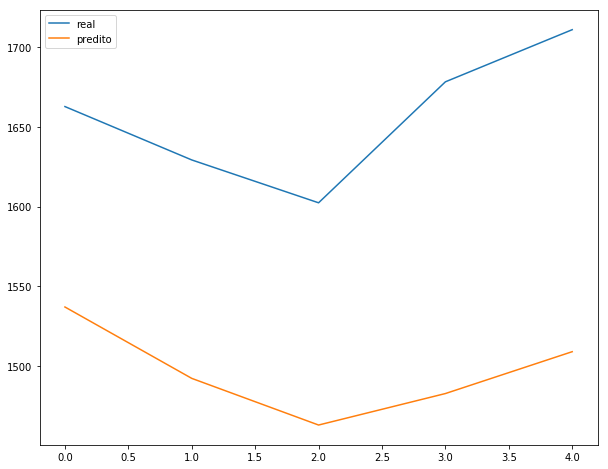

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [147]:
dias = 5
n_input = 20
amostras = 4860
lim_treino = amostras - dias

In [148]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')
df = df.iloc[:amostras]
dataset = df['denoised']

In [149]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [150]:
pred = predizer(train, test, n_input, dias, model)

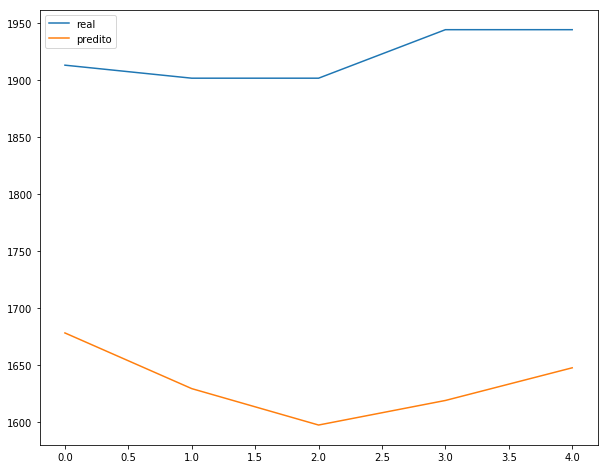

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

#### Analise de previsao de 10 dias

In [152]:
dias = 10
n_input = 60
amostras = 4800
lim_treino = amostras - dias

In [153]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

df = df.iloc[:amostras]

dataset = df['denoised']

train, test = split_dataset(dataset.values, dias, lim_treino)

In [154]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [155]:
model = build_model(train, n_input, dias)

Epoch 1/20
409/409 [==============================] - 16s 38ms/step - loss: 300.0247
Epoch 2/20
409/409 [==============================] - 7s 17ms/step - loss: 298.8316
Epoch 3/20
409/409 [==============================] - 6s 16ms/step - loss: 214.4727
Epoch 4/20
409/409 [==============================] - 6s 16ms/step - loss: 216.1620
Epoch 5/20
409/409 [==============================] - 7s 16ms/step - loss: 182.3454
Epoch 6/20
409/409 [==============================] - 6s 16ms/step - loss: 152.6239
Epoch 7/20
409/409 [==============================] - 6s 16ms/step - loss: 141.9123
Epoch 8/20
409/409 [==============================] - 6s 16ms/step - loss: 129.7103
Epoch 9/20
409/409 [==============================] - 7s 16ms/step - loss: 123.6732
Epoch 10/20
409/409 [==============================] - 6s 16ms/step - loss: 114.5575
Epoch 11/20
409/409 [==============================] - 7s 16ms/step - loss: 104.0155
Epoch 12/20
409/409 [==============================] - 6s 16ms/step - los

In [156]:
pred = predizer(train, test, n_input, dias, model)

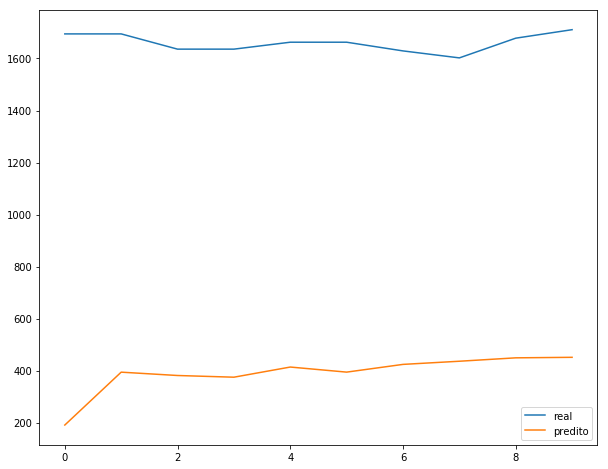

In [157]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [158]:
dias = 10
n_input = 60
amostras = 4850
lim_treino = amostras - dias

In [159]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

df = df.iloc[:amostras]

dataset = df['denoised']

train, test = split_dataset(dataset.values, dias, lim_treino)

In [162]:
model = build_model(train, n_input, dias)

Epoch 1/20
414/414 [==============================] - 13s 32ms/step - loss: 928.8888
Epoch 2/20
414/414 [==============================] - 7s 16ms/step - loss: 1625.2388
Epoch 3/20
414/414 [==============================] - 6s 16ms/step - loss: 600.0852
Epoch 4/20
414/414 [==============================] - 6s 16ms/step - loss: 270.4345
Epoch 5/20
414/414 [==============================] - 6s 16ms/step - loss: 197.5946
Epoch 6/20
414/414 [==============================] - 6s 16ms/step - loss: 327.6670
Epoch 7/20
414/414 [==============================] - 6s 15ms/step - loss: 247.4822
Epoch 8/20
414/414 [==============================] - 6s 15ms/step - loss: 292.8587
Epoch 9/20
414/414 [==============================] - 6s 15ms/step - loss: 250.0124
Epoch 10/20
414/414 [==============================] - 7s 16ms/step - loss: 233.5787
Epoch 11/20
414/414 [==============================] - 6s 16ms/step - loss: 290.8248
Epoch 12/20
414/414 [==============================] - 7s 16ms/step - lo

In [163]:
pred = predizer(train, test, n_input, dias, model)

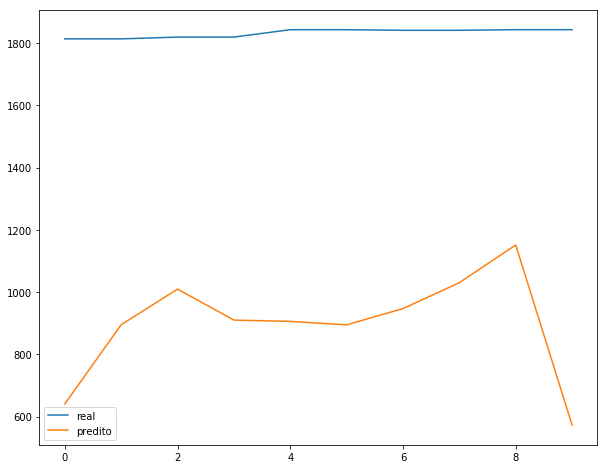

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()